<a href="https://colab.research.google.com/github/mustaphaouamen/projects/blob/master/deep_object_detection_of_crops_weeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
import json
warnings.filterwarnings('ignore')

In [2]:
path = '/content/DATA/'

Preprocessing

In [3]:
df = pd.read_csv('/content/DATA/agri_label.csv')

In [4]:
df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  agri_0_9354.jpeg    512     512  weed    63   120   425   442
1  agri_0_9354.jpeg    512     512  weed     0     1   180   148
2  agri_0_7574.jpeg    512     512  crop    95   167   453   469
3  agri_0_8960.jpeg    512     512  weed    52    76   422   353
4   agri_0_417.jpeg    512     512  weed     7    75   511   411

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2072 non-null   object
 1   width     2072 non-null   int64 
 2   height    2072 non-null   int64 
 3   class     2072 non-null   object
 4   xmin      2072 non-null   int64 
 5   ymin      2072 non-null   int64 
 6   xmax      2072 non-null   int64 
 7   ymax      2072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 129.6+ KB


now checking all labeled images are available in the folder or not

In [6]:
folder_images=df['filename']

In [7]:
len(folder_images)

2072

In [8]:
train_images = folder_images[:1000]

In [9]:
test_images = folder_images[1000:]

In [10]:
j=0
for i in tqdm(list(df['filename'].unique())):
    if i in folder_images:
        j+=1
print(j)

100%|██████████| 1300/1300 [00:00<00:00, 164820.60it/s]

0


Visualizing the Dataset

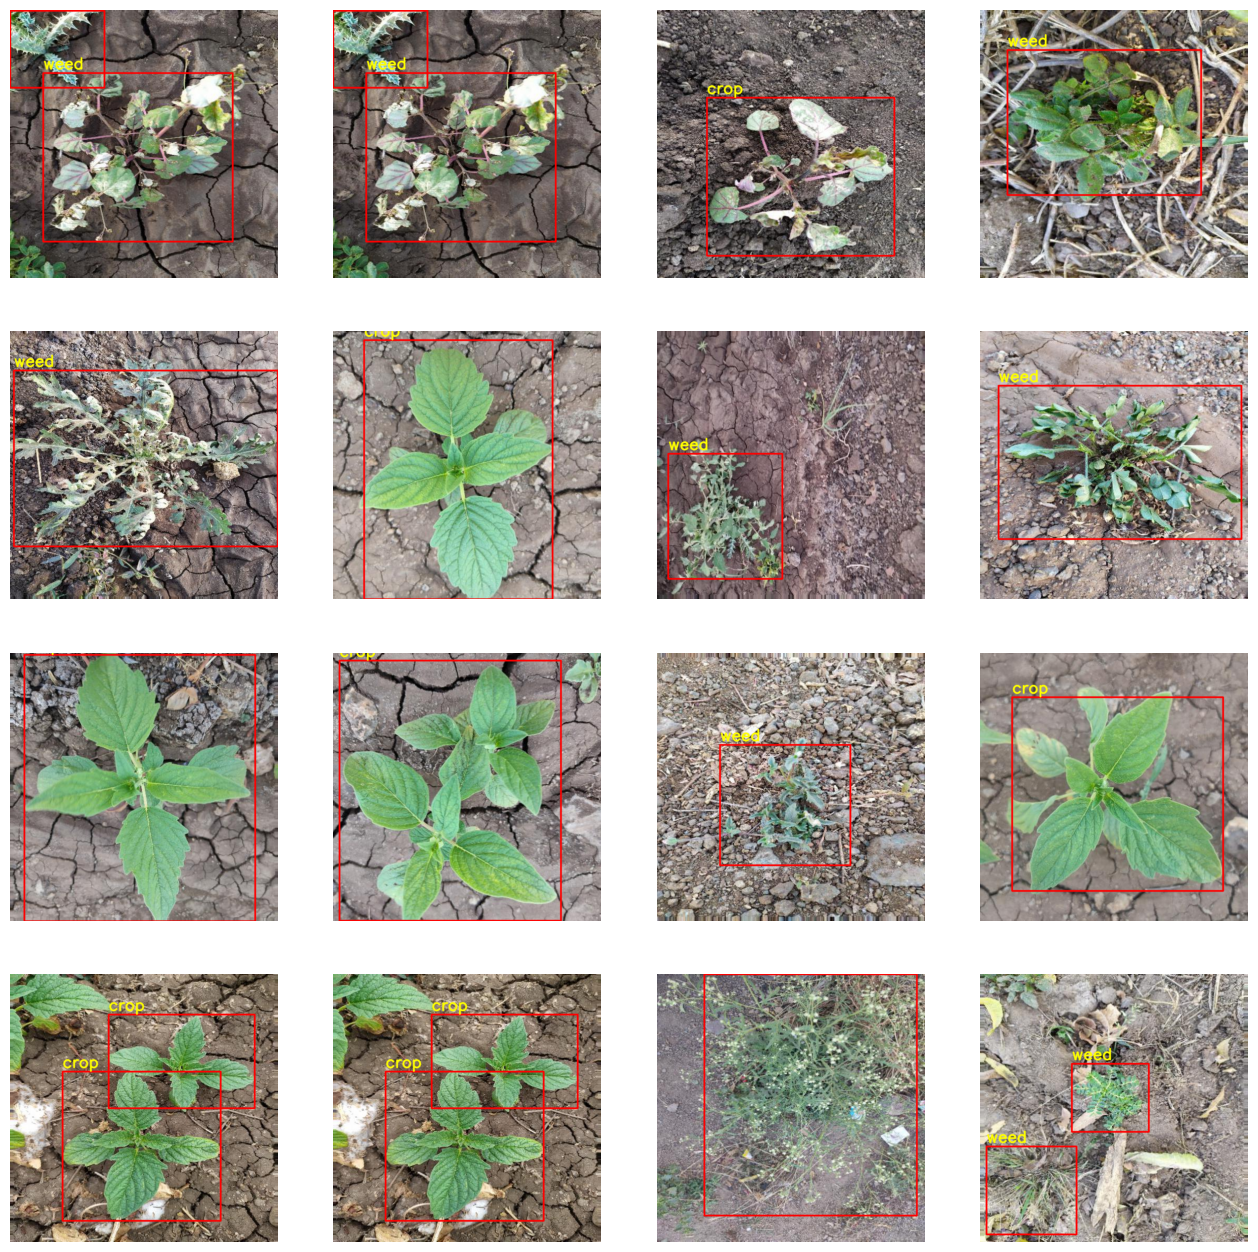

In [11]:
import matplotlib.pyplot as plt
import cv2

_, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(16):
    temp_df = df[df['filename'] == folder_images[i]].reset_index(drop=True)
    try:
        temp_img = cv2.imread(path + folder_images[i])
        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image {path + folder_images[i]}: {e}")
        continue

    for j in range(len(temp_df)):
        rect = cv2.rectangle(temp_img, (temp_df.loc[j,'xmin'], temp_df.loc[j,'ymin']),
                             (temp_df.loc[j,'xmax'], temp_df.loc[j,'ymax']), (255, 0, 0), 2, cv2.LINE_AA)
        rect_text = cv2.putText(rect, temp_df.loc[j,'class'], (temp_df.loc[j,'xmin'], temp_df.loc[j,'ymin']-8),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

    axes[i // 4, i % 4].imshow(rect_text)
    axes[i // 4, i % 4].axis('off')

plt.show()


Selective search

In [12]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [13]:
path='/content/DATA/'
img = cv2.imread(path+folder_images[4])
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()

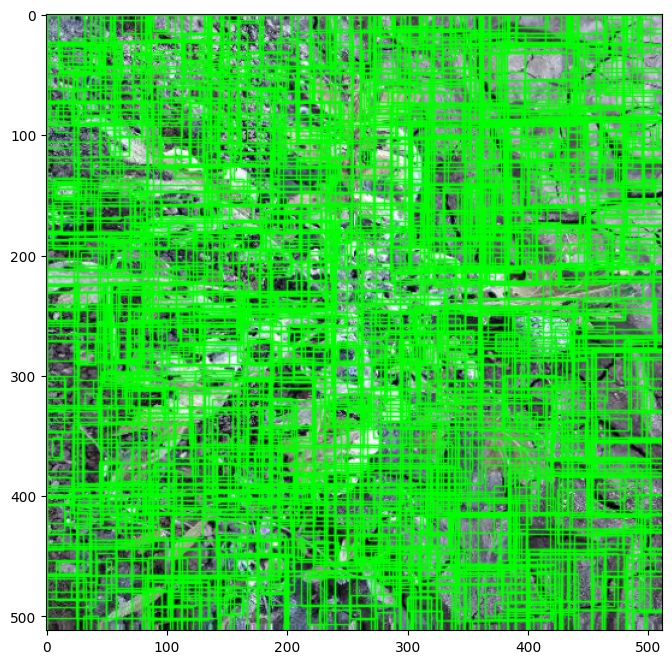

In [14]:
sel_rects = rects[:1200]
imOut = img.copy()
for i, rect in (enumerate(sel_rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(8,8))
plt.imshow(imOut)

**Saving all region proposal of all images**

In [15]:
train_data = {}
test_data  = {}

In [16]:
#converting numpy instantant into python datatype
import json
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [17]:
with open('train.json','w+') as output_file:
    json.dump(train_data,output_file,cls=MyEncoder)

In [18]:
with open('test.json','w+') as output_file:
    json.dump(test_data,output_file,cls=MyEncoder)

checking our conversion is right or wrong

In [19]:
with open('train.json') as train:
    train_json = json.load(train)

In [20]:
with open('test.json') as test:
    test_json = json.load(test)

In [21]:
train_json == train_data

True

In [22]:
test_json == test_data

True

Loading pretrained CNN model

In [23]:
train_path = '/content/DATA/'

In [24]:
test_path = '/content/DATA/'

Preparing The Data

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224,3)

In [27]:
train_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_data = train_generator.flow_from_directory(train_path,target_size=(224, 224),color_mode="rgb", class_mode="categorical",batch_size=BATCH_SIZE,shuffle=True,subset='training')

val_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 subset='validation')
test_generator  = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory(test_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",shuffle=False,
                                                 batch_size=BATCH_SIZE)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


Model Architecture

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=IMAGE_SIZE))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

for layer in baseModel.layers:
    layer.trainable = False
model = Model(inputs=baseModel.input, outputs=headModel)

opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
early_stop = EarlyStopping(patience=2,monitor='val_loss')